In [6]:
import time
import math
import qiskit
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram

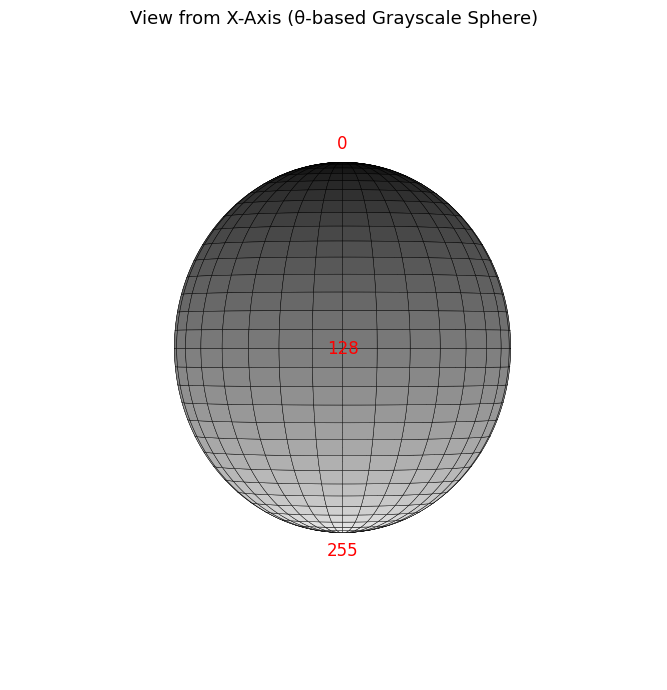

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# θ → grayscale
def theta_to_grayscale(theta):
    quantized = int((theta / np.pi) * 255)
    return np.clip(quantized, 0, 255)

# 단위 구 표면 생성
def generate_unit_sphere(n_theta=256, n_phi=256):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    gray_values = np.vectorize(theta_to_grayscale)(theta)
    return x, y, z, gray_values

# 시각화 + 시점 x축으로 설정
def visualize_sphere_from_x_axis(x, y, z, gray_values):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        x, y, z,
        facecolors=plt.cm.gray(gray_values / 255),
        rstride=8, cstride=8,
        linewidth=0.3,
        edgecolor='k',
        antialiased=True,
        shade=False
    )
        # 주요 grayscale 라벨 (0, 128, 255)
    for g in [0, 128, 255]:
        theta = (g / 255.0) * np.pi
        x_txt = 1.1 * np.sin(theta)
        y_txt = 0
        z_txt = 1.1 * np.cos(theta)
        ax.text(x_txt, y_txt, z_txt, f"{g}", color='red', fontsize=12, ha='center', va='center')
        
    ax.set_box_aspect([1, 1, 1])
    ax.set_axis_off()
    ax.view_init(elev=0, azim=0)  # ← 시점을 x축 방향으로 설정
    ax.set_title("View from X-Axis (θ-based Grayscale Sphere)", fontsize=13)
    plt.tight_layout()
    plt.show()

# 실행
x, y, z, gray_values = generate_unit_sphere()
visualize_sphere_from_x_axis(x, y, z, gray_values)


In [3]:
import numpy as np
import pandas as pd

# θ 구간: 0~π 까지를 255등분 (총 255 구간, 256 경계점)
theta_bins_rad = np.linspace(0, np.pi, 257)
theta_bins_deg = np.degrees(theta_bins_rad)

# 각 θ 구간에 대해 대응되는 grayscale 값 정의 (0~254 구간 → grayscale = 구간 인덱스)
lookup_table = []

for i in range(256):
    entry = {
        'Grayscale Value': i,
        'Theta Start (rad)': theta_bins_rad[i],
        'Theta End (rad)': theta_bins_rad[i+1],
        'Theta Start (deg)': theta_bins_deg[i],
        'Theta End (deg)': theta_bins_deg[i+1],
    }
    lookup_table.append(entry)

# DataFrame 생성 및 저장
lookup_df = pd.DataFrame(lookup_table)
lookup_df.to_excel("theta_to_grayscale_lookup_with_degrees.xlsx", index=False)


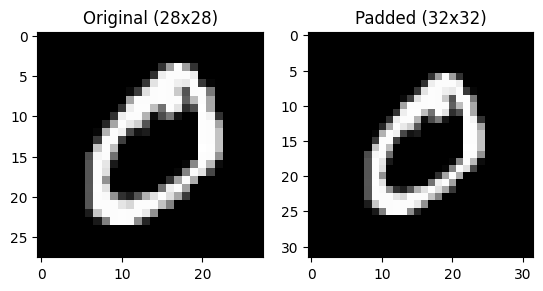

In [7]:
import cv2

# gray_scale 이미지 불러오기
mnist = cv2.imread('mnist.png', 0) # 인수를 0으로 전달하면 gray 이미지가 로드된다.
padded_mnist = np.pad(mnist, pad_width=((2, 2), (2, 2)), mode='constant', constant_values=0)

# 결과 출력
plt.subplot(1, 2, 1)
plt.imshow(mnist, cmap='gray')
plt.title("Original (28x28)")

plt.subplot(1, 2, 2)
plt.imshow(padded_mnist, cmap='gray')
plt.title("Padded (32x32)")

plt.show()

In [8]:
padded_mnist_flat = padded_mnist.flatten()
theta_mnist = padded_mnist_flat * np.pi/510
theta_mnist

array([0., 0., 0., ..., 0., 0., 0.])

33.78748 sec
5.529619561588333e-06


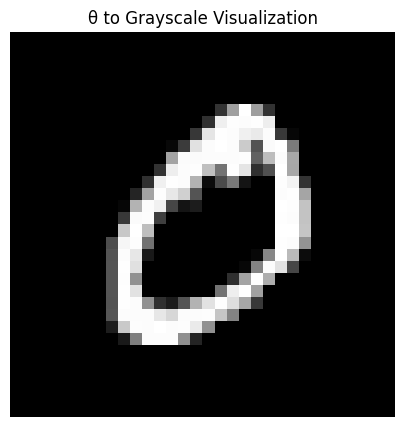

In [15]:
start = time.time()
input_tuple = padded_mnist.shape

w_bits = int(np.ceil(math.log(padded_mnist.shape[1],2)))
h_bits = int(np.ceil(math.log(padded_mnist.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

num_ind_bits = int(h_bits + w_bits)

if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(w_bits+h_bits, 'q1')
c = QuantumRegister(1,'q0')
cr = ClassicalRegister(O.size+c.size, "cl")

qc_image = QuantumCircuit(c,O, cr)

qc_image.id(c)
qc_image.h(O)


qc_image.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])


for i, theta in enumerate(theta_mnist):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind): 
            qc_image.barrier()
            qc_image.x(O[k])
    qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
    qc_image.barrier()
    
    if  i!=len(theta_mnist) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           

qc_image.x(O)

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result = aer_sim.run(t_qc_image, shots=8000000).result()
counts = result.get_counts()
pixel_theta_recon = []

pixel_theta = []

for i in range(0, len(theta_mnist)):
    for item in counts.items():
        key = item[0]
        amount = item[1]
        state = key[0]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_theta.append((state,bin_coord, amount))
        else:
            pass

# ======================== theta ====================================
        
theta_result_dict = {}
for state in pixel_theta:
    key = state[1]
    value = state[2] 
    if key in theta_result_dict:
        theta_result_dict[key] += value  
    else:
        theta_result_dict[key] = value  

theta_result_list = [(key, value) for key, value in theta_result_dict.items()]

theta_state_0 = []

def fill_missing_theta_for_state_0(pixel_theta):
    # (1) 모든 가능한 theta 10bit 문자열
    all_theta = {format(i, '010b') for i in range(1024)}

    # (2) 기존 pixel_theta 중 state가 '0'인 것만 필터링
    state_0_entries = [(state, theta, amount) for state, theta, amount in pixel_theta if state == '0']

    # (3) 존재하는 theta 추출
    existing_theta_0 = {theta for state, theta, amount in state_0_entries}

    # (4) 누락된 theta 확인
    missing_theta_0 = all_theta - existing_theta_0

    # (5) 누락된 항목을 amount=0으로 추가
    filled_entries = list(pixel_theta)  # 원본 복사

    for theta in missing_theta_0:
        filled_entries.append(('0', theta, 0))

    return filled_entries

def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

for state, theta, amount in sort_by_theta_bin(fill_missing_theta_for_state_0(pixel_theta)):
    if not int(state):
        theta_state_0.append((theta, amount))


for i in range(0, len(theta_mnist)):
    try:
        theta = np.arccos((theta_state_0[i][1]/theta_result_list[i][1])**(1/2))
        pixel_theta_recon.append(theta)
    except ZeroDivisionError:
        print("ZeroDivisionError")


end = time.time()
print(f"{end - start:.5f} sec")

recon_theta = list(reversed(pixel_theta_recon))

error = []
for i in range(len(theta_mnist)):
    err = (recon_theta[i] - theta_mnist[i])**2
    error.append(err)

MSE = sum(error)/len(theta_mnist) 
print(MSE)


# (1) 정규화: θ 값을 0~255로 스케일링
normalized_gray = [theta * 510 / np.pi for theta in recon_theta]
#normalized_gray = [theta * 255 / np.pi for theta in pixel_theta_recon]
# (2) numpy 배열로 변환 및 32×32 reshape
gray_image = np.array(normalized_gray).reshape(32, 32)
cropped_image = gray_image[2:-2, 2:-2] 
# (3) 시각화
plt.figure(figsize=(5, 5))
plt.imshow(gray_image, cmap='gray', vmin=0, vmax=255)
plt.title('θ to Grayscale Visualization')
plt.axis('off')
plt.show()

In [13]:
import pandas as pd

def find_matching_gray(theta_prime, lut_path="theta_to_grayscale_lookup_with_degrees.xlsx"):
    # 엑셀 로드
    df = pd.read_excel(lut_path)

    # 1차 필터링: θ 범위 내에 있는 행 추출
    theta_filtered = df[(df['Theta Start (rad)'] <= theta_prime) & (df['Theta End (rad)'] >= theta_prime)]

    # 2차 필터링: ϕ 범위 내에 있는 행 추출

    return theta_filtered[['Grayscale Value','Theta Start (rad)','Theta End (rad)']]

In [25]:
type(recon_theta)

list

In [21]:
for i in range(len(recon_theta)):
    err = theta_mnist[i] * 255 / np.pi - recon_theta[i] * 255 / np.pi
    if err > 1:
        print("pred  = ",recon_theta[i], recon_theta[i] * 255 / np.pi )
        print("Answer  = ",theta_mnist[i], theta_mnist[i] * 255 / np.pi)
        print(find_matching_gray(recon_theta[i]))
        print("===================================================================")

In [22]:
# (1) 두 이미지 준비 (float 형태로 변환)
original = mnist.astype(float)
reconstructed = cropped_image.astype(float)

# (2) 오차 계산
error_array = np.abs(original - reconstructed)

# (3) 픽셀 좌표 + 값 기록
records = []

for y in range(28):
    for x in range(28):
        err = error_array[y, x]
        if err > 0:  # 0보다 큰 경우만 기록
            records.append({
                'x': x,
                'y': y,
                'original_gray': original[y, x],
                'reconstructed_gray': reconstructed[y, x],
                'error': err
            })

# (4) DataFrame 생성 및 정렬
df_error = pd.DataFrame(records)
df_error_sorted = df_error.sort_values(by='error', ascending=False)

# (5) 오차가 0보다 큰 상위 5개 출력
df_error_sorted.head(5)


,x,y,original_gray,reconstructed_gray,error
136,8,20,249.0,251.794016,2.794016
109,20,16,253.0,255.000000,2.000000
81,20,12,253.0,255.000000,2.000000
29,20,7,253.0,255.000000,2.000000
92,8,14,253.0,255.000000,2.000000
